# Transfer Learning with MobileNetV3

<a name='1'></a>
## 1 - Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow_addons as tfa

from train_utils.augmenters import data_augmenter, data_augmenter_fruit360
from train_utils.callbacks import LossHistory, LRCallBack
from train_utils.utils import is_in
from train_utils.custom_model import CustomModel
from train_utils.losses import crossentropy_loss
from train_utils.dataset import food_dataset

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


<a name='1'></a>
## 2 - Datasets

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset, cv_dataset = food_dataset(BATCH_SIZE, IMG_SIZE)

from train_utils.dataset import fruit360_classes, all_class_names

print(
    tf.data.experimental.cardinality(train_dataset),
    train_dataset,
    sep = '\n'
)

Found 195823 files belonging to 296 classes.
Using 193865 files for training.
Found 195823 files belonging to 296 classes.
Using 1958 files for validation.
Found 89089 files belonging to 96 classes.
tf.Tensor(6059, shape=(), dtype=int64)
<BatchDataset shapes: ((None, 224, 224, 3), (None, 296)), types: (tf.float32, tf.float32)>


<a name='2'></a>
## 3 - Preprocess and Augment Training Data
(https://www.tensorflow.org/tutorials/images/data_augmentation).

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=128, reshuffle_each_iteration=True)

<a name='3'></a>
## 4 - Using MobileNetV3


In [4]:
IMG_SHAPE = IMG_SIZE + (3,)

preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

mobile_v3_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
)

Note the last 2 layers here. They are the so called top layers, and they are responsible of the classification in the model

In [5]:
print("Number of layers in the base model: ", len(mobile_v3_model.layers))

Number of layers in the base model:  276


In [6]:
image_batch, label_batch = next(iter(train_dataset))
print(image_batch.shape, label_batch.shape)
NUM_CLASSES = label_batch.shape[-1]

(32, 224, 224, 3) (32, 296)


## Hyper-Parameters

In [8]:
## 0 to skip
FIXED_LAYERS_V3 = 256    # [0, 276]
DROPOUT_BEFORE = 0       # [0, 0.5]
TOP_DENSE_LAYER = 0    # (300, 1280) U {0}
DROPOUT_AFTER = 0        # [0, 0.5]
L1, L2 = 0, 0            # [1e-9, 1e-4] U {0}
GRADIENT_CLIP = 100       # [5, 100]

LR = (-4, -6)            # [-5.5, -2.5]
EPOCHS = 10              # [0, 30]

In [9]:
def food_model(image_shape=IMG_SIZE):
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV3Large(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
    )
    base_model.trainable = True

    # Fine-tune from this layer onwards
    fine_tune_at = FIXED_LAYERS_V3
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
        
    reg = tf.keras.regularizers.L1L2(L1, L2)
        
    inputs = tf.keras.Input(shape=input_shape)
    x = preprocess_input(inputs)
    x = base_model(x)
    x = tfl.GlobalAveragePooling2D()(x)
    if DROPOUT_BEFORE:
        x = tf.keras.layers.Dropout(DROPOUT_BEFORE)(x)
    if TOP_DENSE_LAYER:
        x = tfl.Dense(
            TOP_DENSE_LAYER,
            activation='relu', 
            kernel_regularizer=reg
        )(x)
    if DROPOUT_AFTER:
        x = tf.keras.layers.Dropout(DROPOUT_AFTER)(x)
    outputs = tfl.Dense(
        NUM_CLASSES, 
        activation='softmax', 
        kernel_regularizer=reg
    )(x)
    
    model = CustomModel(inputs, outputs)
    
    return model

### Estimate optimal learning rate

In [10]:
optimizer = tf.keras.optimizers.Adam(clipvalue=GRADIENT_CLIP)

metrics = [
    tf.keras.metrics.CategoricalAccuracy(name='top1'),
    tf.keras.metrics.TopKCategoricalAccuracy(k=4, name='top4'),
]
model2 = food_model(IMG_SIZE)
model2.compile(
    loss=crossentropy_loss,
    optimizer=optimizer,
    metrics=metrics,
)
model2.summary()

Model: "custom_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
MobilenetV3large (Functional (None, 7, 7, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 296)               379176    
Total params: 4,605,608
Trainable params: 2,150,056
Non-trainable params: 2,455,552
_________________________________________________________________


In [11]:
tqdm_callback = tfa.callbacks.TQDMProgressBar(
    metrics_separator=' ; ',
    epoch_bar_format='{n_fmt}/{total_fmt} ; ETA: {remaining}s {bar} {desc}',
    metrics_format='{name}: {value:0.4f}',
    update_per_second=1,
)
lr_callback = LRCallBack(epochs=EPOCHS, l_r=LR)

history = model2.fit(
    train_dataset,
    validation_data=cv_dataset,
    epochs=lr_callback.epochs,
    verbose=0,
    callbacks=[tqdm_callback, lr_callback],
)

Training:   0%|                                             0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/6059 ; ETA: ?s                                                                    

lr set to: 0.0001
Epoch 2/10


0/6059 ; ETA: ?s                                                                    

lr set to: 6.309573444801929e-05
Epoch 3/10


0/6059 ; ETA: ?s                                                                    

lr set to: 3.9810717055349695e-05
Epoch 4/10


0/6059 ; ETA: ?s                                                                    

lr set to: 2.511886431509577e-05
Epoch 5/10


0/6059 ; ETA: ?s                                                                    

lr set to: 1.5848931924611107e-05
Epoch 6/10


0/6059 ; ETA: ?s                                                                    

lr set to: 9.999999999999979e-06
Epoch 7/10


0/6059 ; ETA: ?s                                                                    

lr set to: 6.309573444801917e-06
Epoch 8/10


0/6059 ; ETA: ?s                                                                    

lr set to: 3.9810717055349615e-06
Epoch 9/10


0/6059 ; ETA: ?s                                                                    

lr set to: 2.5118864315095717e-06
Epoch 10/10


0/6059 ; ETA: ?s                                                                    

lr set to: 1.5848931924611077e-06


Text(0.5, 1.0, 'Training Loss')

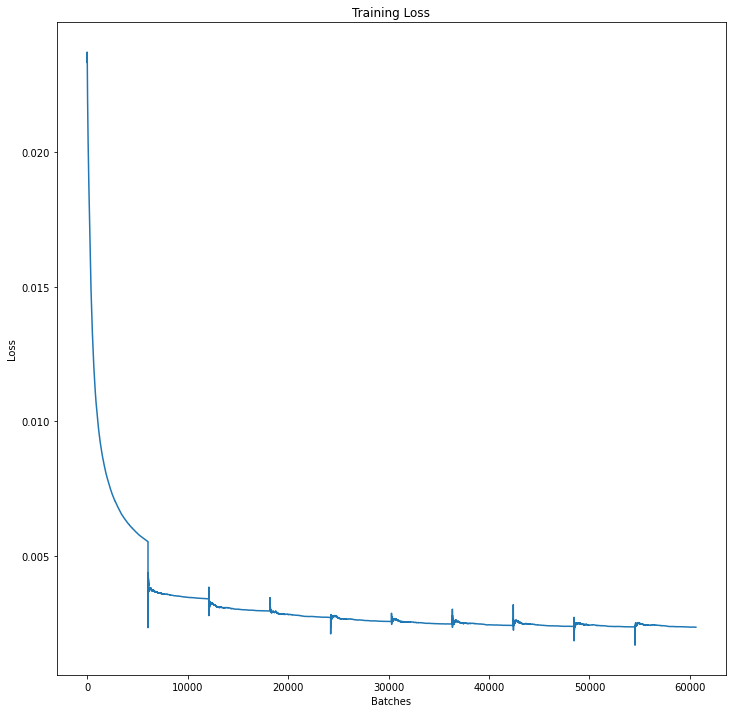

In [12]:
plt.figure(figsize=(12, 12))
plt.plot(lr_callback.batch_losses)
plt.ylabel('Loss')
plt.xlabel('Batches')
plt.title('Training Loss')

Plot the training and validation accuracy:

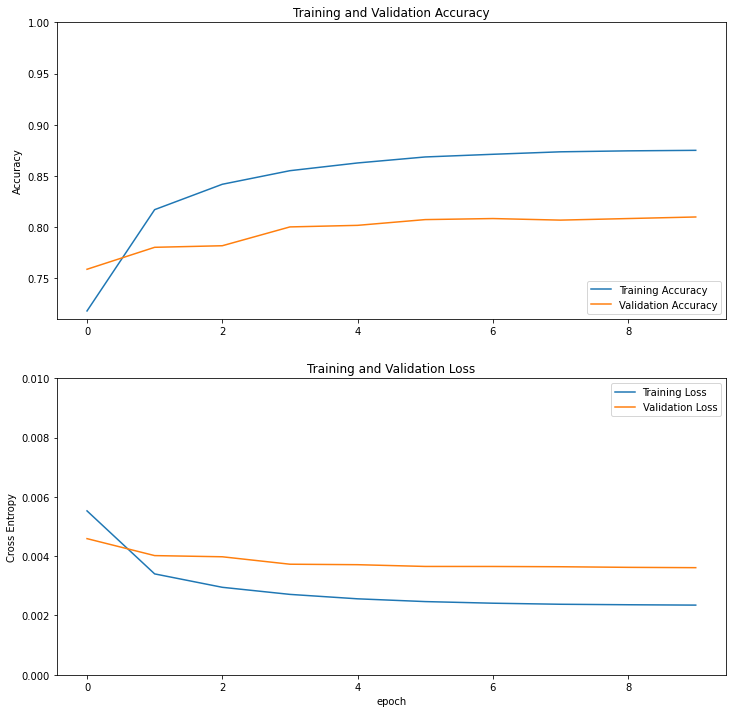

In [13]:
acc = history.history['top1']
val_acc = history.history['val_top1']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.01])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Save the model

In [ ]:
model2.save('models\\main.h5')
model2.save_weights('models\\main_weights.h5')
with open("models\\main_classes.txt", 'w') as file:
    for class_name in all_class_names:
        file.write(class_name + '\n')

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [23]:
def input_gen():
    for image_batch, _ in cv_dataset.take(60):
        print(image_batch.shape)
        yield [image_batch]


converter.representative_dataset = tf.lite.RepresentativeDataset(
    input_gen
)
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()
open("models\\main.tflite", "wb").write(tflite_model)

c:\users\arlak\pycharmprojects\indianfoodtf\venv\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: C:\Users\arlak\AppData\Local\Temp\tmpa8zhs_5y\assets


INFO:tensorflow:Assets written to: C:\Users\arlak\AppData\Local\Temp\tmpa8zhs_5y\assets


5163968

## Check Network Predictions

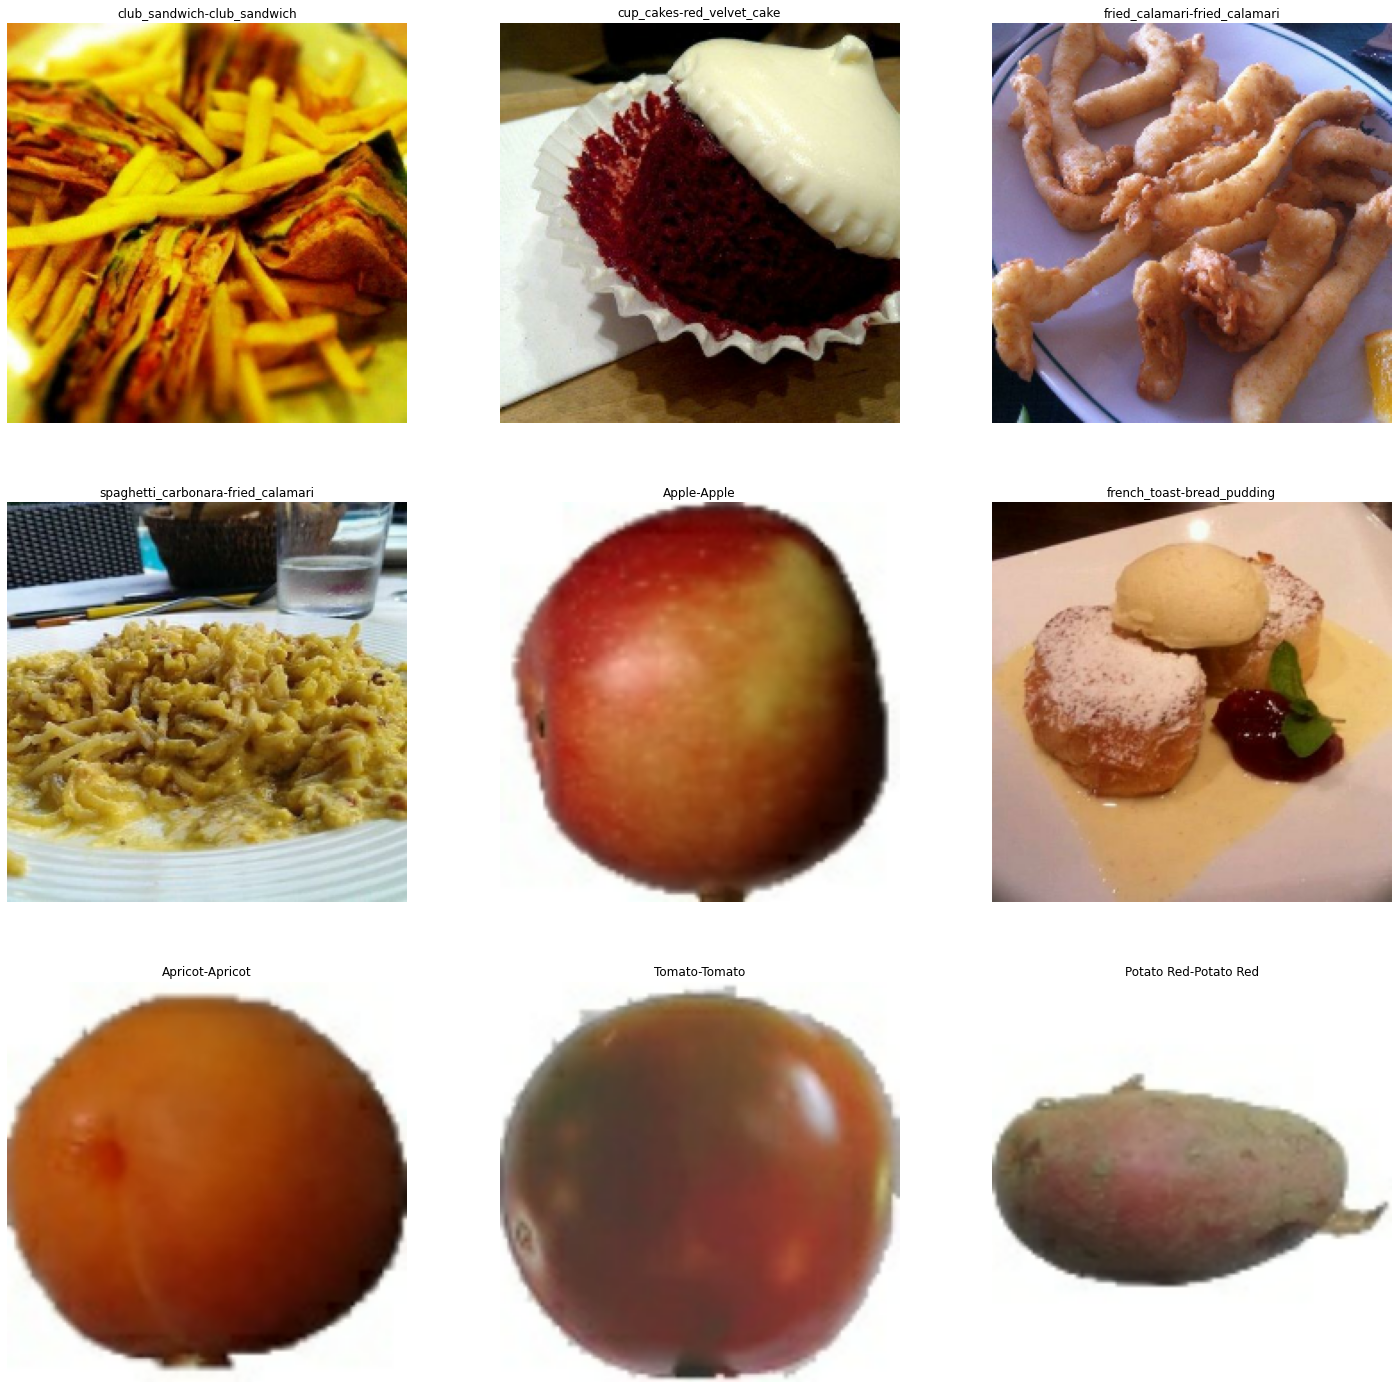

In [12]:
image_batch, label_batch = next(iter(cv_dataset))
plt.figure(figsize=(25, 25))
for item in range(9):
    ax = plt.subplot(3, 3, item + 1)
    plt.imshow(image_batch[item].numpy().astype("uint8"))
    probs = model2(image_batch)[item]
    label = all_class_names[tf.math.argmax(label_batch[item])]
    pred = all_class_names[tf.math.argmax(probs)]
    plt.title(label + '-' + pred)
    plt.axis("off")